In [10]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate
from scipy.signal import find_peaks

In [3]:
# --- FUNCTION: Find anthropometry from basic measurements ---
def anthropometry_from_basic_measurements(body_weight, thigh_length, shank_length):
    """
    Returns segment parameters for inverse dynamics given simple measurements.
    
    Inputs:
    - body_weight: total body weight in kg
    - thigh_length: thigh length (hip to knee) in meters
    - shank_length: shank length (knee to ankle) in meters
    
    Outputs:
    - l1, l2: segment lengths
    - a1, a2: COM positions from proximal end
    - m1, m2: segment masses
    - I1, I2: segment moments of inertia
    """
    
    # Mass fractions
    m1_frac = 0.105  # thigh
    m2_frac = 0.0465 # shank
    
    m1 = body_weight * m1_frac
    m2 = body_weight * m2_frac
    
    # Segment lengths
    l1 = thigh_length
    l2 = shank_length
    
    # COM locations from proximal end
    a1 = 0.43 * l1
    a2 = 0.43 * l2
    
    # Moments of inertia about COM (approx cylinder model)
    k1 = 0.322  # thigh
    k2 = 0.303  # shank
    I1 = m1 * (k1 * l1)**2
    I2 = m2 * (k2 * l2)**2
    
    return l1, l2, a1, a2, m1, m2, I1, I2

In [ ]:
# --- FUNCTION: Detect stress peaks using scipy ---
def detect_stress_peaks(t, tau, moment_arm, area, smoothing_window=7, min_prominence=0.2):
    """ 
    Computes stress from torque, moment arm, and area time series, 
    smooths it, and detects peaks above a threshold using scipy.signal.find_peaks.

    Inputs:
    - t: time array
    - tau: torque time series (N*m)
    - moment_arm: moment arm time series (m)
    - area: contact/tendon area time series (m^2)
    - smoothing_window: int, moving average window size
    - min_prominence: float, fraction of max stress for peak threshold (0..1)

    Outputs:
    - stress: raw stress time series (Pa)
    - stress_smooth: smoothed stress time series (Pa)
    - peaks: indices of detected stress peaks
    """
    tau = np.asarray(tau)
    moment_arm = np.asarray(moment_arm)
    area = np.asarray(area)

    # Compute force + stress
    F = tau / (moment_arm + 1e-12)
    stress = np.abs(F / (area + 1e-12))

    # Smooth stress
    w = np.ones(smoothing_window) / smoothing_window
    stress_smooth = np.convolve(stress, w, mode='same')

    # Peak detection with scipy
    threshold = min_prominence * np.max(stress_smooth)
    peaks, _ = find_peaks(stress_smooth, height=threshold)

    return stress, stress_smooth, peaks


In [ ]:
# --- FUNCTION: Detect stress peaks ---
def detect_stress_peaks(t, tau, moment_arm, area, smoothing_window=7, min_prominence=0.2):
    """ 
    Computes stress from torque, moment arm, and area time series, 
    smooths it, and detects peaks above a threshold.

    Inputs:
    - t: time array
    - tau: torque time series (N*m)
    - moment_arm: moment arm time series (m)
    - area: contact/tendon area time series (m^2)
    - smoothing_window: int, moving average window size
    - min_prominence: float, fraction of max stress for peak threshold (0..1)

    Outputs:
    - stress: raw stress time series (Pa)
    - stress_smooth: smoothed stress time series (Pa)
    - peaks: indices of detected stress peaks
    """
    tau = np.asarray(tau)
    moment_arm = np.asarray(moment_arm)
    area = np.asarray(area)

    # Compute force + stress (take absolute value)
    F = tau / (moment_arm + 1e-12)
    stress = np.abs(F / (area + 1e-12))   # <- absolute value

    # Smooth
    w = np.ones(smoothing_window) / smoothing_window
    stress_smooth = np.convolve(stress, w, mode='same')

    # Peak detection
    peaks = []
    threshold = min_prominence * np.max(stress_smooth)
    for i in range(1, len(stress_smooth)-1):
        if stress_smooth[i] > stress_smooth[i-1] and stress_smooth[i] > stress_smooth[i+1]:
            if stress_smooth[i] >= threshold:
                peaks.append(i)

    return stress, stress_smooth, np.array(peaks, dtype=int)

In [5]:
# --- FUNCTION: Process IMU and GRF data (knee + ankle) ---
def process_imu_grf_data(knee_imu, ankle_imu, grf_data, fs):
    """
    Processes knee and ankle IMU data along with GRF for 2-DOF inverse dynamics.

    Inputs:
    - knee_imu: array-like
        Knee IMU time series angles (rad)
    - ankle_imu: array-like
        Ankle/shank IMU time series angles (rad)
    - grf_data: dict
        Dictionary containing 'Fx' and 'Fz' arrays
    - fs: float
        Sampling frequency (Hz)

    Outputs:
    - t: np.ndarray
        Time array
    - q1, q2: np.ndarray
        Knee and ankle joint angles for dynamics
        q1 = knee angle (thigh-shank)
        q2 = ankle angle relative to shank
    - dq1, dq2: np.ndarray
        Angular velocities
    - ddq1, ddq2: np.ndarray
        Angular accelerations
    - Fext: np.ndarray
        External forces array (2 x N)
    """
    t = np.arange(len(knee_imu)) / fs
    dt = 1/fs

    # 2-DOF joint angles
    q1 = knee_imu
    q2 = ankle_imu - knee_imu  # relative ankle angle

    # velocities & accelerations
    dq1 = np.gradient(q1, dt)
    dq2 = np.gradient(q2, dt)
    ddq1 = np.gradient(dq1, dt)
    ddq2 = np.gradient(dq2, dt)

    # external forces
    Fx = grf_data.get('Fx', np.zeros_like(grf_data['Fz']))
    Fz = grf_data['Fz']
    Fext = np.vstack([Fx, Fz])

    return t, q1, q2, dq1, dq2, ddq1, ddq2, Fext

In [6]:
# --- FUNCTION: Run inverse dynamics with stress analysis (knee + ankle) ---
def run_inverse_dynamics_with_stress(t, q1, q2, dq1, dq2, ddq1, ddq2, Fext, l1, l2, a1, a2, m1, m2, I1, I2):
    """ 
    Runs inverse dynamics to compute joint torques and performs stress analysis
    for a 2-link planar system (knee + ankle).

    Inputs:
    - t: time array
    - q1, q2: joint angles time series (knee, relative ankle)
    - dq1, dq2: joint angular velocities time series
    - ddq1, ddq2: joint angular accelerations time series
    - Fext: external force array (2 x N)
    - l1, l2: segment lengths
    - a1, a2: segment COM distances
    - m1, m2: segment masses
    - I1, I2: segment moments of inertia

    Outputs:
    - df: pandas DataFrame with results
    - peaks: indices of detected stress peaks
    """

    g = 9.81
    N = len(t)

    # Extract vertical ground reaction force
    Fz = Fext[1, :]

    # ---------- Dynamics helper functions ----------
    def inertia_matrix(q2):
        d1 = I1 + I2 + m1*(a1**2) + m2*(l1**2 + a2**2)
        d2 = I2 + m2*(a2**2)
        M11 = d1 + 2*m2*l1*a2*np.cos(q2)
        M12 = d2 + m2*l1*a2*np.cos(q2)
        return np.array([[M11, M12], [M12, d2]])

    def coriolis_vector(q2, dq1, dq2):
        h = -m2*l1*a2*np.sin(q2)
        return np.array([h*(2*dq1*dq2 + dq2*dq2), h*(-dq1*dq1)])

    def gravity_vector(q1, q2):
        g1 = (m1*a1 + m2*l1)*g*np.cos(q1) + m2*a2*g*np.cos(q1+q2)
        g2 = m2*a2*g*np.cos(q1+q2)
        return np.array([g1, g2])

    def foot_jacobian(q1, q2):
        J11 = -l1*np.sin(q1) - l2*np.sin(q1 + q2)
        J12 = -l2*np.sin(q1 + q2)
        J21 =  l1*np.cos(q1) + l2*np.cos(q1 + q2)
        J22 =  l2*np.cos(q1 + q2)
        return np.array([[J11, J12], [J21, J22]])

    # ---- Compute Torques ----
    tau = np.zeros((N, 2))
    for i in range(N):
        M = inertia_matrix(q2[i])
        C = coriolis_vector(q2[i], dq1[i], dq2[i])
        G = gravity_vector(q1[i], q2[i])
        J = foot_jacobian(q1[i], q2[i])
        ddq = np.array([ddq1[i], ddq2[i]])
        tau[i] = M.dot(ddq) + C + G - J.T.dot(Fext[:, i])

    tau_knee = tau[:, 0]     # Proximal knee torque
    tau_ankle = tau[:, 1]    # Distal ankle torque

# ---- STRESS ANALYSIS ----

# Knee
    knee_moment_arm = 0.04 + 0.01*np.sin(2*np.pi*1.5*t)   # example, m
    knee_area = 432e-6                                     # m^2
    knee_stress, knee_stress_smooth, knee_peaks = detect_stress_peaks(
        t=t,
        tau=tau_knee,
        moment_arm=knee_moment_arm,
        area=knee_area,
        smoothing_window=7,
        min_prominence=0.2
    )

# Ankle
    ankle_moment_arm = 0.03 + 0.008*np.sin(2*np.pi*1.5*t)  # example, m
    ankle_area = 350e-6                                    # m^2
    ankle_stress, ankle_stress_smooth, ankle_peaks = detect_stress_peaks(
        t=t,
        tau=tau_ankle,
        moment_arm=ankle_moment_arm,
        area=ankle_area,
        smoothing_window=7,
        min_prominence=0.2
    )

    # CREATE TABLE
    df = pd.DataFrame({
        't (s)': t,
        'knee_angle (rad)': q1,
        'ankle_angle_rel (rad)': q2,
        'tau_knee (Nm)': tau_knee,
        'tau_ankle (Nm)': tau_ankle,
        'Fz (N)': Fz,
        'knee_moment_arm (m)': knee_moment_arm,
        'ankle_moment_arm (m)': ankle_moment_arm,
        'knee_stress (Pa)': knee_stress,
        'knee_stress_smooth (Pa)': knee_stress_smooth,
        'ankle_stress (Pa)': ankle_stress,
        'ankle_stress_smooth (Pa)': ankle_stress_smooth,
        'knee_is_peak': [1 if i in knee_peaks else 0 for i in range(N)],
        'ankle_is_peak': [1 if i in ankle_peaks else 0 for i in range(N)]
    })


    # PLOT
    plt.figure(figsize=(12,8))

    # Torques
    plt.subplot(3,1,1)
    plt.plot(t, tau_knee, label='Knee Torque')
    plt.plot(t, tau_ankle, label='Ankle Torque')
    plt.title("Joint Torques")
    plt.ylabel("Torque (Nm)")
    plt.grid(True)
    plt.legend()

    # Knee Stress
    plt.subplot(3,1,2)
    plt.plot(t, knee_stress, label="Raw Knee Stress", alpha=0.5)
    plt.plot(t, knee_stress_smooth, label="Smoothed Knee Stress", linewidth=2)
    if len(knee_peaks) > 0:
        plt.scatter(t[knee_peaks], knee_stress_smooth[knee_peaks], color='red', label='Knee Peaks')
    plt.title("Knee Joint Stress (proxy)")
    plt.ylabel("Stress (Pa)")
    plt.grid(True)
    plt.legend()

    # Ankle Stress
    plt.subplot(3,1,3)
    plt.plot(t, ankle_stress, label="Raw Ankle Stress", alpha=0.5)
    plt.plot(t, ankle_stress_smooth, label="Smoothed Ankle Stress", linewidth=2)
    if len(ankle_peaks) > 0:
        plt.scatter(t[ankle_peaks], ankle_stress_smooth[ankle_peaks], color='red', label='Ankle Peaks')
    plt.title("Ankle Joint Stress (proxy)")
    plt.xlabel("Time (s)")
    plt.ylabel("Stress (Pa)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df, knee_peaks, ankle_peaks

In [8]:
# --- FUNCTION: RUN EVERYTHING ---
def run_everything(body_weight, thigh_length, shank_length,
                   knee_imu, ankle_imu, grf_data, fs):
    """
    Runs the full pipeline: anthropometry, data processing, inverse dynamics,
    and stress analysis.

    Inputs:
    - body_weight: total body weight in kg
    - thigh_length: thigh length (hip to knee) in meters
    - shank_length: shank length (knee to ankle) in meters
    - knee_imu: knee IMU angle time series (rad)
    - ankle_imu: ankle IMU angle time series (rad)
    - grf_data: dict with 'Fx' and 'Fz' arrays
    - fs: sampling frequency (Hz)

    Outputs:
    - df: pandas DataFrame with results
    - knee_peaks: indices of detected knee stress peaks
    - ankle_peaks: indices of detected ankle stress peaks
    """

    # Step 1: Anthropometry
    l1, l2, a1, a2, m1, m2, I1, I2 = anthropometry_from_basic_measurements(
        body_weight, thigh_length, shank_length)

    # Step 2: Process IMU and GRF data
    t, q1, q2, dq1, dq2, ddq1, ddq2, Fext = process_imu_grf_data(
        knee_imu, ankle_imu, grf_data, fs)

    # Step 3: Inverse dynamics with stress analysis
    df, knee_peaks, ankle_peaks = run_inverse_dynamics_with_stress(
        t, q1, q2, dq1, dq2, ddq1, ddq2, Fext,
        l1, l2, a1, a2, m1, m2, I1, I2)

    # Print results all pretty
    print(tabulate(df.head(10), headers='keys', tablefmt='fancy_grid'))
    print("knee_peaks:", knee_peaks)
    print("ankle_peaks:", ankle_peaks)

    return df, knee_peaks, ankle_peaks

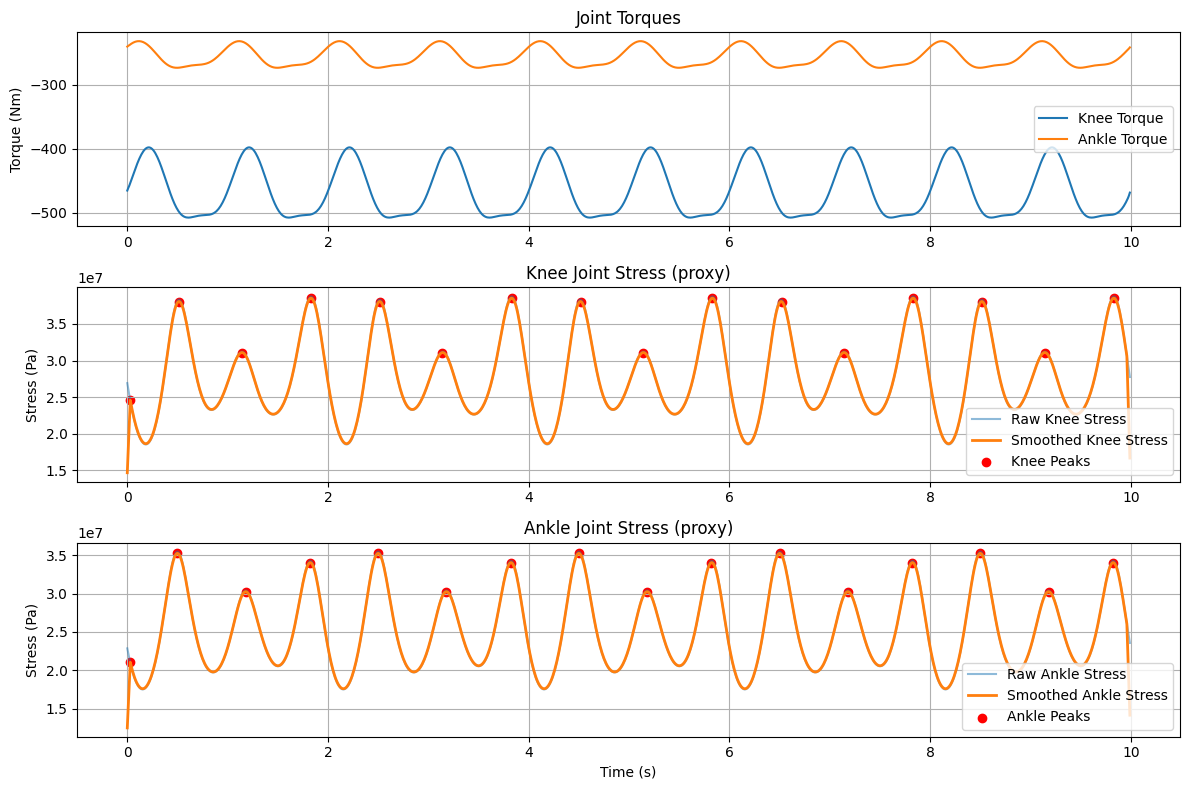

╒════╤═════════╤════════════════════╤═════════════════════════╤═════════════════╤══════════════════╤══════════╤═══════════════════════╤════════════════════════╤════════════════════╤═══════════════════════════╤═════════════════════╤════════════════════════════╤════════════════╤═════════════════╕
│    │   t (s) │   knee_angle (rad) │   ankle_angle_rel (rad) │   tau_knee (Nm) │   tau_ankle (Nm) │   Fz (N) │   knee_moment_arm (m) │   ankle_moment_arm (m) │   knee_stress (Pa) │   knee_stress_smooth (Pa) │   ankle_stress (Pa) │   ankle_stress_smooth (Pa) │   knee_is_peak │   ankle_is_peak │
╞════╪═════════╪════════════════════╪═════════════════════════╪═════════════════╪══════════════════╪══════════╪═══════════════════════╪════════════════════════╪════════════════════╪═══════════════════════════╪═════════════════════╪════════════════════════════╪════════════════╪═════════════════╡
│  0 │    0    │           0.5      │              0.012132   │        -465.203 │         -240.041 │      700 │ 

In [ ]:
# --- TEST ---
if __name__ == "__main__":

    # Dummy sampling frequency
    fs = 100

    # Dummy anthropometric parameters
    body_weight = 70  # kg
    thigh_length = 0.4  # m
    shank_length = 0.4   # m

    # These two are only included to make the dummy data, they goes away in real use
    t = np.arange(0, 10, 1/fs)
    N = len(t)

    # Dummy IMU data (sinusoidal knee and ankle angles)
    knee_imu = 0.5 * np.sin(2 * np.pi * 1 * t) + 0.5
    ankle_imu = 0.3 * np.sin(2 * np.pi * 1 * t + np.pi/4) + 0.3

    # Dummy GRF data (constant vertical force)
    grf_data = {
        'Fx': np.zeros(N),
        'Fz': 700 * np.ones(N)  # constant vertical GRF
    }

    # Run everything
    df, knee_peaks, ankle_peaks = run_everything(
        body_weight, thigh_length, shank_length,
        knee_imu, ankle_imu, grf_data, fs
    )
